<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/Model_training_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TRY:
 - Dropout to 0.2/0.5 instead (*)
 - Bidirectional LSTM (*)
 - Learning rate scheduling (and/or stop-resume)
 - TimeDistributed (Conv1D) or ConvLSTM
 - exponential smoothing

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
%cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
import pandas as pd
df = pd.read_csv("data/final_data.csv", index_col = 0, parse_dates = True)

In [0]:
df = df[df.index > "2016-06-02"]
df['density'] = (df.flow * 60) / df.speed

In [0]:
cols = ["speed", "flow", "density", "speed_limit", "holiday", "weekend"]
continuous_cols = ["speed", "flow", "density"]
discrete_cols = ["speed_limit", "holiday", "weekend"]
df = df[cols]

### First resample to elmininate some noise

In [0]:
import numpy as np
def resample_df(df, freq = "15T"):
    r_df = df.copy()
    r_df = r_df.resample(freq).agg({
           "speed": np.mean, "flow": np.sum, "density": np.mean, "speed_limit": np.median, "holiday": np.median, "weekend": np.median})
    return r_df

In [0]:
r_df = resample_df(df, freq = "15T")

### Exponential smoothing

In [0]:
# r_df_smoothed = r_df.copy()
# for col in continuous_cols:
#     r_df_smoothed[col] = r_df_smoothed[col].ewm(span = 3).mean()

In [0]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize = (10, 5), dpi = 150)
# r_df['speed'][0:300].plot(ax = ax, style = 'r', label = 'Speed')
# r_df_smoothed['speed'][0:300].plot(ax = ax, style = 'b', label = ' Exponential moving average')
# r_df_15['speed'][0:100].plot(ax = ax, style = 'g', label = 'Speed_15')
# r_df_15['speed'].ewm(span = 3).mean()[0:100].plot(ax = ax, style = 'w', label = 'Speed_15_ema')

### Train, val, test split

In [0]:
def train_split(split_df):
    train = split_df[split_df.index.year < 2019].copy()
    val = split_df[len(train): -len(split_df[split_df.index > "2019-06"]) - 1].copy()
    test = r_df[len(train) + len(val):].copy()
    return train, val, test

train, val, test = train_split(r_df)

### MinMax Scaling

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
X_train = scaler.transform(train)
y_train = X_train[:, 0]
X_val = scaler.transform(val)
y_val = X_val[:, 0]
X_test = scaler.transform(test)
y_test = X_test[:, 0]

In [12]:
%tensorflow_version 2.x
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

lookback = int(7 * 24 * (60 / 15))
batch_size = 512

train_gen = TimeseriesGenerator(data = X_train, targets = y_train, length = lookback, batch_size = batch_size)
val_gen = TimeseriesGenerator(data = X_val, targets = y_val, length = lookback, batch_size = batch_size)
test_gen = TimeseriesGenerator(data = X_test, targets = y_test, length = lookback, batch_size = batch_size)
 
#explore_generator = TimeseriesGenerator(X_train, y_train.shift(-forecast+1).values)

TensorFlow 2.x selected.


In [0]:
# ML
import tensorflow as tf
import pdb
import matplotlib.pyplot as plt
import datetime, os
#%load_ext tensorboard

In [0]:
############## Define Neural Network Class ##############
class neural_net(tf.keras.Model):
    def __init__(self, lookback = 24 * 4, regularization = 1e-6):
        super(neural_net, self).__init__()

        # Define l2 regularization
        self.regularization = regularization
        regu = tf.keras.regularizers.l2(self.regularization)

        # Define lookback
        self.lookback = lookback

        # Define discrete feature layers
        self.discrete_flatten = tf.keras.layers.Flatten()
        self.discrete_prelu1 = tf.keras.layers.PReLU()
        self.discrete_bnorm1 = tf.keras.layers.BatchNormalization()
        self.discrete_dense1 = tf.keras.layers.Dense(64)
        self.discrete_prelu2 = tf.keras.layers.PReLU()

        # Define time feature layers
        # Time 1
        self.time1_conv1 = tf.keras.layers.Conv1D(filters = 64, kernel_size = (1))
        self.time1_prelu1 = tf.keras.layers.PReLU()
        self.time1_maxpool = tf.keras.layers.MaxPooling1D(pool_size = 4)
        self.time1_lstm1 = tf.keras.layers.LSTM(units = 16, dropout = 0.5, recurrent_dropout = 0.5, input_shape = (self.lookback, 16))
        self.time1_prelu2 = tf.keras.layers.PReLU()

        # Time 2
        self.time2_conv1 = tf.keras.layers.Conv1D(filters = 64, kernel_size = (1))
        self.time2_prelu1 = tf.keras.layers.PReLU()
        self.time2_maxpool = tf.keras.layers.MaxPooling1D(pool_size = 4)
        self.time2_lstm1 = tf.keras.layers.LSTM(units = 16, dropout = 0.5, recurrent_dropout = 0.5, input_shape = (self.lookback, 16))
        self.time2_prelu2 = tf.keras.layers.PReLU()

        # Define Merged layers
        self.bnorm1 = tf.keras.layers.BatchNormalization()
        self.dense1 = tf.keras.layers.Dense(32)
        self.prelu1 = tf.keras.layers.PReLU()
        self.bnorm2 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(1, activation = 'linear',)

    # Define the forward propagation
    def call(self, inputs):
        
        # Split time and discrete inputs
        x_time = inputs[:, :, :-3]
        x_discrete = inputs[:, :, -3:]

        # Run discrete layers
        x_discrete = self.discrete_flatten(x_discrete)
        x_discrete = self.discrete_prelu1(x_discrete)
        #x_discrete = self.discrete_bnorm1(x_discrete)
        x_discrete = self.discrete_dense1(x_discrete)
        x_discrete = self.discrete_prelu2(x_discrete)

        # Run time layers
        x_time1 = self.time1_conv1(x_time)
        x_time1 = self.time1_prelu1(x_time1)
        x_time1 = self.time1_maxpool(x_time1)
        x_time1 = self.time1_lstm1(x_time1)
        x_time1 = self.time1_prelu2(x_time1)
        
        x_time2 = self.time2_conv1(x_time)
        x_time2 = self.time2_prelu1(x_time2)
        x_time2 = self.time2_maxpool(x_time2)
        x_time2 = self.time2_lstm1(x_time2)
        x_time2 = self.time2_prelu2(x_time2)

        # Concat layers
        x = tf.concat([x_time1, x_time2, x_discrete], axis = 1)
        x = self.bnorm1(x)
        x = self.dense1(x)
        x = self.prelu1(x)
        x = self.bnorm2(x)
        x = self.dense2(x)
        
        # Return output
        return x

# Create an instance of you neural network model
model = neural_net(lookback = lookback, regularization = 1e-7)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)

# Define loss function
mse_loss_fn = tf.keras.losses.MeanSquaredError()

# Compile model
model.compile(optimizer = optimizer, loss = mse_loss_fn)

# Define callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6, restore_best_weights = True)
learning_rate_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 0)
#%tensorboard --logdir logs

In [17]:
# Train model
history = model.fit(train_gen, validation_data = val_gen, epochs = 50, callbacks = [early_stopping, learning_rate_reduce]) #, tensorboard_callback])
train_loss, val_loss = history.history['loss'], history.history['val_loss']

  ...
    to  
  ['...']
Train for 176 steps, validate for 27 steps
Epoch 1/50
176/176 [==============================] - 132s 749ms/step - loss: 0.0854 - val_loss: 0.0096
Epoch 2/50
176/176 [==============================] - 120s 684ms/step - loss: 0.0053 - val_loss: 0.0064
Epoch 3/50
176/176 [==============================] - 118s 673ms/step - loss: 0.0039 - val_loss: 0.0054
Epoch 4/50
176/176 [==============================] - 119s 675ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 5/50
176/176 [==============================] - 118s 673ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 6/50
176/176 [==============================] - 121s 689ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 7/50
176/176 [==============================] - 122s 693ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 8/50
176/176 [==============================] - 121s 690ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 9/50
176/176 [==============================] - 121s 688ms/step - loss: 0.0026 - val_loss: 0.0

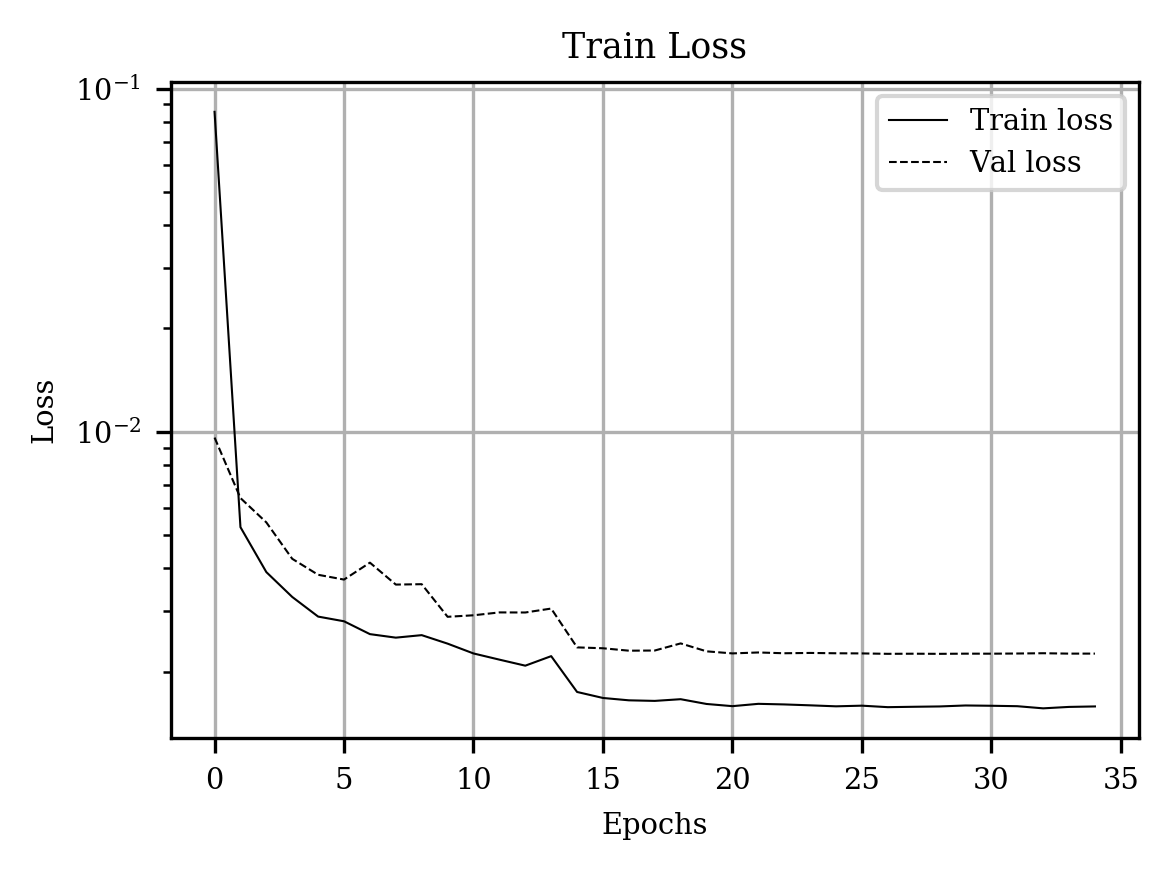

In [41]:
# Plot test and validation loss
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (4, 3)
plt.figure()
plt.semilogy(train_loss, 'k-', lw = 0.5)
plt.semilogy(val_loss, 'k--', lw = 0.5)
plt.xlabel("Epochs", fontsize = 'x-small')
plt.ylabel("Loss", fontsize = 'x-small')
plt.legend(['Train loss', 'Val loss'])
plt.grid(True)
plt.title('Train Loss', fontsize = 'small')
plt.tight_layout()
plt.show()
plt.savefig("plots/train_loss_maxpool.pdf", format = "pdf")

In [0]:
val_pred = model.predict(val_gen)

In [0]:
# predictions = pd.DataFrame(data = np.exp(val_log.iloc[lookback:, 0].values), index = val_log[lookback:].index, columns = ['True speed'])
# predictions["Predicted speed"] = np.exp(val_pred)
# predictions["Speed limit"] =  np.where(val.iloc[lookback:, val.columns.get_loc('speed_limit')] > 0.5, 130, 100)

In [0]:
predictions = pd.DataFrame(data = r_df.iloc[len(train) + lookback : -len(r_df[r_df.index > "2019-06"]) - 1, 0].values, index = val[lookback:].index, columns = ['True speed'])
# predictions = pd.DataFrame(data = val.iloc[lookback:, 0].values, index = val[lookback:].index, columns = ['True speed'])
fudge = val.copy()
fudge.iloc[lookback:, 0] = val_pred
predictions["Predicted speed"] = scaler.inverse_transform(fudge)[lookback:, 0]
predictions["Speed limit"] =  np.where(val.iloc[lookback:, val.columns.get_loc('speed_limit')] > 0.5, 130, 100)

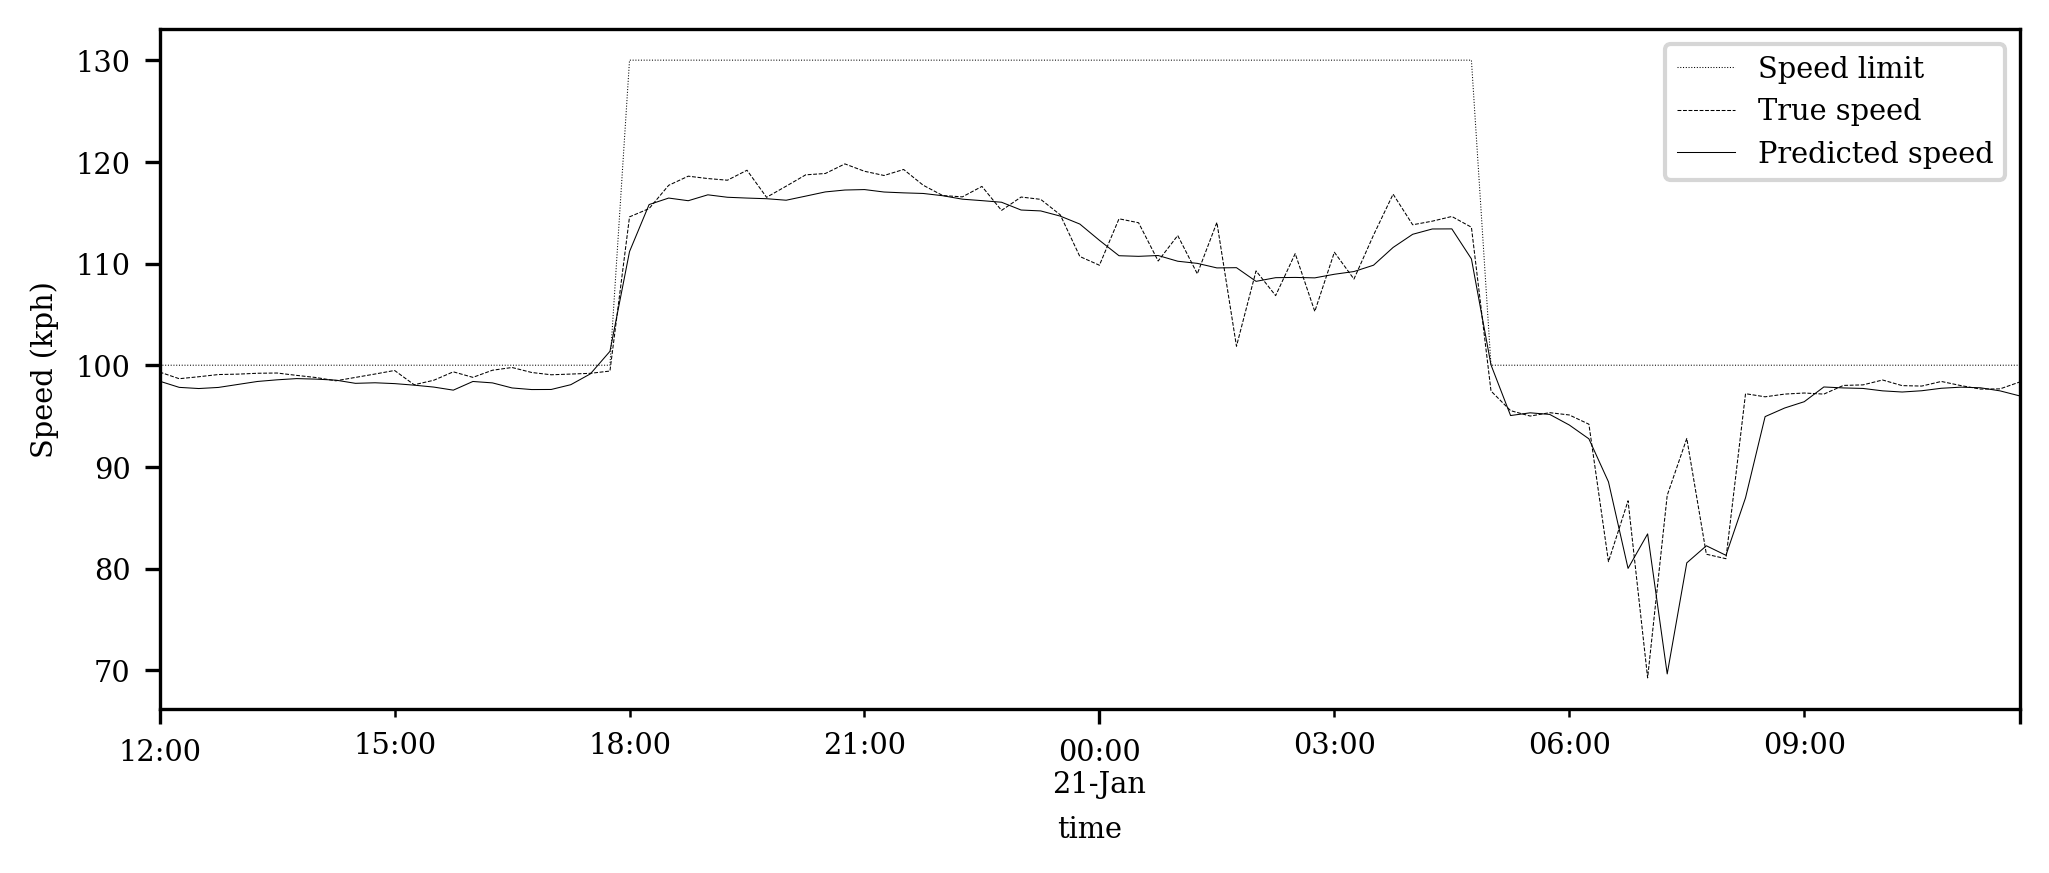

In [70]:
import matplotlib as mpl
start = 1200
end = 1296
y1 = predictions["Speed limit"]
y2 = predictions["True speed"]
y3 = predictions["Predicted speed"]
fig, ax = plt.subplots(figsize = (8, 3), sharey = True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')
ax.set_xlabel('Time (15m)', fontsize = 'x-small')
ax.set_ylabel('Speed (kph)', fontsize = 'x-small')

y1[start:end].plot(ax = ax, style = 'k:', lw = 0.25, label = "Speed limit")
y2[start:end].plot(ax = ax, style = 'k--', lw = 0.25, label = "True speed")
y3[start:end].plot(ax = ax, style = 'k-', lw = 0.25, label = "Predicted speed")
_, labels = ax.get_legend_handles_labels()
plt.legend(labels)
plt.savefig("plots/prediction_example.pdf", format = "pdf")

In [23]:
print(f"Model R^2: {np.mean((predictions['True speed'] - predictions['Predicted speed'])**2)}")
speed = predictions['True speed'].values
print(f"Naive R^2: {np.mean((speed[1:] - speed[:-1])**2)}")

Model R^2: 28.165695041352546
Naive R^2: 24.976024417436317


In [24]:
#Evaluate on test set
test_loss = model.evaluate(test_gen)
print('Test Loss: ' + str(test_loss))

  ...
    to  
  ['...']
39/39 [==============================] - 5s 132ms/step - loss: 0.0014
Test Loss: 0.0013596507644531531
